In [63]:
# TODO!!!
## Currently does not pull playoffs -- Only have playoffs for first two seasons?
## Some seasons are missing week information, I did not try to figure it out in these cases and just entered the matches in the order they appeared
## Track history so you can graph players over time
## Graphing should exclude 0 elo seasons
## Record Peak Elo

# Make case insensitive!!!
# Add win rates, maybe even faction specific

In [1]:
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

In [153]:
import pandas as pd
from collections import defaultdict
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

In [4]:
early_data_sheet = "1fd-dMfTfOwcOkNwIDbjMhQgTLZjS1COTPWi3f96Bols"

In [5]:
class SheetsService():
    def __init__(self):
        self.service = self.build_service()
        self.sheet = self.service.spreadsheets()


    def build_service(self):
        """Shows basic usage of the Sheets API.
        Prints values from a sample spreadsheet.
        """
        creds = None
        # The file token.json stores the user's access and refresh tokens, and is
        # created automatically when the authorization flow completes for the first
        # time.
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        # If there are no (valid) credentials available, let the user log in.
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
            # Save the credentials for the next run
            with open('token.json', 'w') as token:
                token.write(creds.to_json())

        try:
            service = build('sheets', 'v4', credentials=creds)
            return service

        except HttpError as err:
            print(err)
        
        
    def get_sheet_as_df(self, sheet_id, cell_range, has_header = False, columns = None):
        # Call the Sheets API
        result = self.sheet.values().get(spreadsheetId=sheet_id,
                                    range=cell_range).execute()
        values = result.get('values', [])

        if not values:
            print('No data found.')
            
        if len(values) < 10:
            return "SKIP"
        
        if has_header:
            return pd.DataFrame(data = values[1:], columns = values[0])
        else:
            if columns != None:
                return pd.DataFrame(data = values, columns = columns)
            else:
                return pd.DataFrame(data = values)


In [6]:
service = SheetsService()

In [7]:
sheet_ser = service.service.spreadsheets()

In [8]:
# Example match sheet title: S1W1-FRX-RANDO-2
# A - SEASON
# B- WEEK
# C - GAME
# D - GAME LENGTH
# E - TEAM
# F - FACTION
# G - RESULT
# H - PILOT
# I - SCORE
# J - KILLS
# K - DEATHS
# L - ASSISTS
# M - AI KILLS
# N - CAP SHIP DMG

# Create known aliases map
# Build player - elo board. Teams do not matter
# Can build team elo board as well, MAYBE MAYBE MAYBE or insert teams as players (maybe have a player/team column) -- will require some name continuity research

# Go through each season 
# Go through each week of that season
# Go through each match of that week
# For each match extract all pilots
# If pilot does not exist, create an entry with default elo (1500)
# Retrieve each pilot elo and divide into teams. 
# Calculate avg elo for each team.
# Adjust elo for each pilot based on W or L
# Adjust elo for each team based on W or L
# At end of each season, save elo snapshot as separate dataframe

In [9]:
class EloBuilder():
    def __init__(self):
        self.season = 1
        self.num_seasons = 8
        self.processed_games = 0
        self.skipped_games = 0
        self.elo_board = self.initialize_elo()
        print("Elo initialized")
        self.sheets = SheetsService()
        print("sheets initialized")
        # self.sheets_service = SheetsService()
        # self.sheets = self.sheets_service.sheet
        self.player_aliases = self.make_aliases()
        print("aliases made")
        self.season_sheets = {
            1: ["1fd-dMfTfOwcOkNwIDbjMhQgTLZjS1COTPWi3f96Bols"],
            2: ["1fd-dMfTfOwcOkNwIDbjMhQgTLZjS1COTPWi3f96Bols"],
            3: ["1fd-dMfTfOwcOkNwIDbjMhQgTLZjS1COTPWi3f96Bols"],
            4: ["1elPKPM53ghLvY3FBJcFjWPUizyaWwZZsfyleboNwsbE", "187ceE1WiFRF4PidFwO4tIbetEJKSX3qeWm0rm3h89DY", "1I_5UvfCPgmczgrpKJdvsKMj8GlpqOnSe7l4DQJAE4iE"],
            5: ["19V9fh1BTFFRpyeHdrjJWP37get5T5RNeKCQTFyXVAFM", "10Jz9XpC2mmiVu3BADMHBgZf46qkIxhvCb7Ew83NAZjY", "1lmkI3mXDiE-aOUsWscSxJOOj3Q0t63sj7xD9t4qjaCw"],
            6: ["1g9hhnHwMSJQggbyA6UzHPM7eh9mEm9WPW5XWBgD_8F4", "19E0J_uq_hm9qjG7DPamMFg5eNFW0qZl39Fe4ifCP8bg", "1ov8vuxItAeeya7qSp7GLiIZYFZ6ny7kDIY0ZbZNDwPM"],
            7: ["1VSP1i2hUfhoXfvwGlKiEevkrmtKKASSMfeb-Z7R_FXE"],
            8: ["1tQ6Fvg_jVRny3weLGcrV0vadI9geUe9-_zgSt8HJpLY"]
        }
        self.season_weeks = {
            1: 7,
            2: 6,
            3: 3,
            4: 0,
            5: 0,
            6: 0,
            7: 0,
            8: 0
        }
        self.division_order = ["", "Elite", "Challenger", "Open"]
        self.season_snapshots = defaultdict(pd.DataFrame)
        
    def initialize_elo(self):
        cols = ["player", "score", "games_played", "first_season", "latest_season"]
        df = pd.DataFrame(columns = cols)
        df.set_index("player", inplace = True)
        return df
    
    def add_new_player(self, player):
        player_row = [1500, 0, self.season, self.season]
        self.elo_board.loc[player] = player_row
    
    def make_aliases(self):
        sheet = "1niMELgIKCzxrBOP0BLJdAKDcvtXRA3Zty3sNPbiVorI"
        result = self.sheets.sheet.values().get(spreadsheetId=sheet,
                                    range="NameFixes!A1:Z").execute()
        values = result.get('values', [])
        # data = self.sheets_service.get_sheet_as_df(sheet, "NameFixes!A1:Z")
        aliases = defaultdict(list)
        for name in values:
            aliases[name[0]] = set([n for n in name[1:] if len(n) > 1])
        return aliases
    
    def match_alias(self, name):
        for k,v in self.player_aliases.items():
            if name in v:
                return k  
        return name
    
    ##
    ### Board construction
    ##
    
    def build_elo_board(self):
        for season in range(1,self.num_seasons+1):
            self.process_season()
            self.season_snapshots[self.season] = self.elo_board.copy()
            print(f"--- Processed season: {self.season} ---")
            self.season += 1
        pass
    
    def process_season(self):
        # retrieves all match sheet titles for a season
        if self.season <= 3:
            current_sheet = self.season_sheets[self.season][0]
            meta = self.sheets.sheet.get(spreadsheetId=current_sheet).execute()
            sh = meta.get('sheets', '')
            game_titles = [i['properties']['title'] for i in sh if i['properties']['title'][:3] == f"S{self.season}W"]
            # Currently omits playoffs, can add later
            for week in range(1,self.season_weeks[self.season]+1):
                week_games = [i for i in game_titles if i[:4] == f"S{self.season}W{week}"]
                week_games.sort()
                self.process_week_jareen(week_games, current_sheet)
                print(f"Processed S{self.season}W{week}")
                
        elif self.season <= self.num_seasons:
            current_sheets = self.season_sheets[self.season]
            columns = ["GAME_ID","PILOT","TEAM","POINTS","KILLS","DEATHS","ASSISTS","AI KILLS","CAP SHIIP DMG","FACTION","RESULT"]
            
            for idx, division in enumerate(current_sheets):
                div = idx
                if self.season <= 6:
                    div += 1
                data = self.sheets.get_sheet_as_df(division, 'Data!A1:K', columns = columns)
                data["true_name"] = data.PILOT.apply(self.match_alias)
                game_ids = data.GAME_ID.unique()
                
                for game in game_ids:
                    self.processed_games += 1
                    try:
                        self.process_game(data[data.GAME_ID == game])
                    except Exception as e:
                        self.skipped_games += 1
                        print(f"Skipped {game} -- S{self.season}{self.division_order[idx]}")
                        print(e)
                print(f"Processed S{self.season}{self.division_order[idx]}")

        else:
            print("Ran out of seasons")
            #figure out scheme for later season, has Elite/Challenger/Open for seasons 4-6
            pass
    
    def process_week_jareen(self, games, sheet):
        # processes all match sheets for a week of a season
        for game in games:
            self.processed_games += 1
            cells = f"{game}!A1:N"
            try:
                data = self.sheets.get_sheet_as_df(sheet, cells, has_header = True)
                if type(data) != str:
                    data["true_name"] = data.PILOT.apply(self.match_alias)
                    self.process_game(data)
                else: 
                    print(f"Skipped {game} -- < 10 players")
                    self.skipped_games += 1
            except Exception as e:
                print(f"Skipped {game} -- Other failure")
                print(e)
                break
                self.skipped_games += 1
        sleep(60)
    
    def process_game(self, game):
        # processes match result data from a game
        team_w = game[(game.RESULT == "W") | (game.RESULT == "Win")]
        team_l = game[(game.RESULT == "L") | (game.RESULT == "Loss")]
        if team_w.shape[0] != 0:
            # game_names = {i: match_aliases(i) for i in game.PILOT}
            for name in game.true_name:
                if name not in self.elo_board.index:
                    self.add_new_player(name)
            winner_team_elo = self.calculate_team_elo(team_w)
            loser_team_elo = self.calculate_team_elo(team_l)
            for name in team_w.true_name:
                self.update_player_elo(name, "w", team_w, loser_team_elo)
            for name in team_l.true_name:
                self.update_player_elo(name, "l", team_l, winner_team_elo)
                
    ##
    ### Elo update calculations
    ##
        
    def calculate_team_elo(self, team):
        total = 0
        for player in team.true_name:
            total += self.elo_board.loc[player, "score"]
        return round(total/len(team), 0)
    
    def update_player_elo(self, player, result, team, opp_elo):
        # p_elo = self.elo_board.loc[player].score
        p_elo = self.weighted_player_elo(player, team)
        if result == 'w':
            win_chance = 1.0 / (1 + 10**((opp_elo - p_elo)/400))
            delta = round(32 * (1 - win_chance), 0)
            self.elo_board.loc[player, "score"] += delta
        else:
            win_chance = 1.0 / (1 + 10**((p_elo - opp_elo)/400))
            delta = round(32 * (1 - win_chance), 0)
            self.elo_board.loc[player, "score"] -= delta
        
        self.elo_board.loc[player, "games_played"] += 1
        self.elo_board.loc[player, "latest_season"] = self.season
        
    def weighted_player_elo(self, player, team):
        p_elo = self.elo_board.loc[player].score
        team_elo = self.calculate_team_elo(team[team.PILOT != player])
        wt = (p_elo + team_elo) / 2
        return round(wt, 0)
    
    ##
    ### Graphing stuff below here
    ##

        

In [10]:
elo = EloBuilder()

Elo initialized
sheets initialized
aliases made


In [11]:
elo.build_elo_board()

Skipped S1W1-NPC-1 -- < 10 players
Skipped S1W1-NPC-2 -- < 10 players
Processed S1W1
Skipped S1W2-NPC-1 -- < 10 players
Skipped S1W2-NPC-2 -- < 10 players
Processed S1W2
Processed S1W3
Processed S1W4
Processed S1W5
Processed S1W6
Processed S1W7
--- Processed season: 1 ---
Skipped S2W1-SKL-BAY-1 -- Other failure
14 columns passed, passed data had 7 columns
Processed S2W1
Skipped S2W2-GHST-SKL-1 -- Other failure
14 columns passed, passed data had 7 columns
Processed S2W2
Processed S2W3
Skipped S2W4-F-SPICY-1 -- Other failure
14 columns passed, passed data had 7 columns
Processed S2W4
Processed S2W5
Processed S2W6
--- Processed season: 2 ---
Skipped S3W1-TSQ-1 -- < 10 players
Skipped S3W1-TSQ-2 -- < 10 players
Processed S3W1
Processed S3W2
Skipped S3W3-NOVA-IN-1 -- Other failure
14 columns passed, passed data had 3 columns
Processed S3W3
--- Processed season: 3 ---
Processed S4
Processed S4Elite
Processed S4Challenger
--- Processed season: 4 ---
Processed S5
Processed S5Elite
Processed S5

In [12]:
elo.elo_board.shape

(528, 4)

In [158]:
elo.elo_board.score.mean()

1500.2386363636363

In [20]:
elo.elo_board.sort_values('score', ascending = False)

,score,games_played,first_season,latest_season
player,,,,
Jishiiqua,1802,36,4,6
Hod,1796,82,1,8
Esoda,1786,87,2,8
Matticus_Rex,1761,71,2,8
Dead_Weight,1755,61,3,8
...,...,...,...,...
six8ten,1318,32,6,7
Evil Pepe,1301,31,5,7
Billy_KeyStrokes,1287,16,3,8


In [94]:
def get_player_history(elo, player):
    matched_player = elo.match_alias(player)
    return [elo.season_snapshots[s+1].loc[matched_player].score if matched_player in elo.season_snapshots[s+1].index else 0 for s in range(elo.num_seasons)]

In [126]:
import matplotlib.pyplot as plt

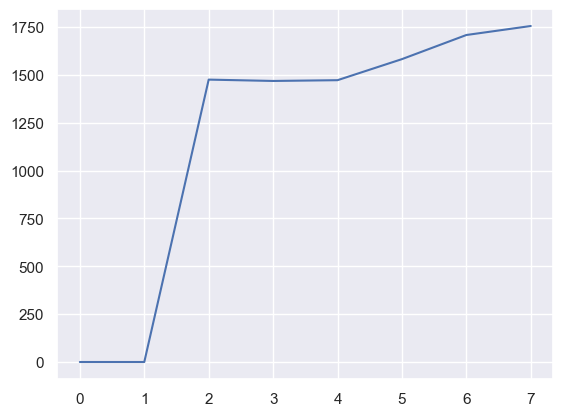

In [155]:
plt.plot(get_player_history(elo, "Dead_Weight"))

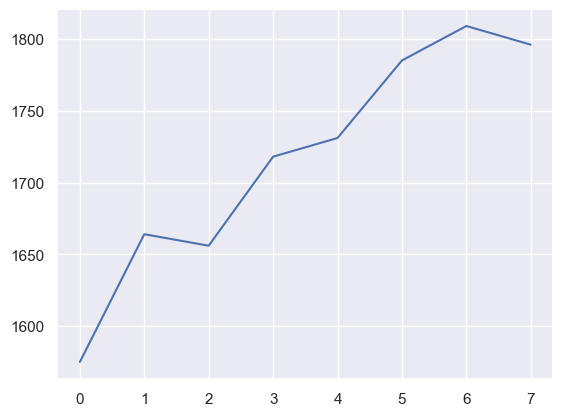

In [154]:
plt.plot(get_player_history(elo, "Hod"))

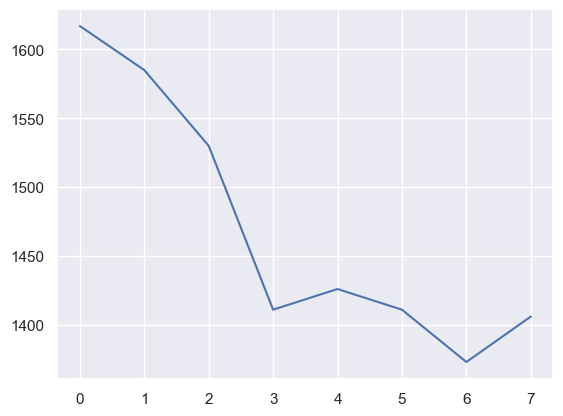

In [161]:
plt.plot(get_player_history(elo, "Pseudo_nine"))

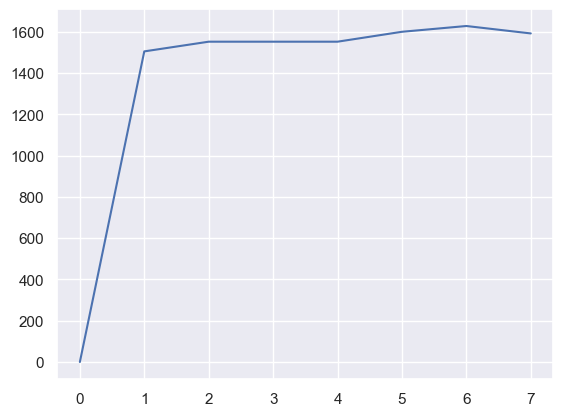

In [167]:
plt.plot(get_player_history(elo, "Eledran"))

In [95]:
get_player_history(elo, "Scribbler")

[0, 1476, 1479, 1574, 1574, 1574, 1680, 1724]

In [47]:
get_player_history(elo, "Eckpired")

[0, 1543, 1511, 1613, 1610, 1592, 1657, 1661]

In [49]:
get_player_history(elo, "Hod")

[1575, 1664, 1656, 1718, 1731, 1785, 1809, 1796]

In [59]:
get_player_history(elo, "dstrik")

[1534, 1584, 1584, 1584, 1584, 1584, 1584, 1584]

In [61]:
get_player_history(elo, "DStrik")

[1516, 1516, 1516, 1516, 1516, 1516, 1516, 1516]

In [162]:
get_player_history(elo, "SuperKev")

[0, 0, 0, 1534, 1539, 1548, 1473, 1456]

In [31]:
df = pd.DataFrame(data = [["esoda", 1500, 0, 1, 1], ["eckpired", 1500, 0, 1, 1]], columns = ["player", "score", "games_played", "first_season", "latest_season"])
df

,player,score,games_played,first_season,latest_season
0,esoda,1500,0,1,1
1,eckpired,1500,0,1,1


In [33]:
df.player.unique()

array(['esoda', 'eckpired'], dtype=object)

In [38]:
df[(df.player == "lions") | (df.player == "eckpired")]

,player,score,games_played,first_season,latest_season
1,eckpired,1500,0,1,1


In [215]:
df.set_index("player", inplace=True)
df

,score,games_played,first_season,latest_season
player,,,,
esoda,1500,0,1,1
eckpired,1500,0,1,1


In [218]:
# df = pd.concat([df, pd.DataFrame({"player": "not tom", "score": 1500, "games_played": 0, "first_season": 1, "latest_season": 1})], axis = 0, ignore_index = True)
df.loc["not tom"] = [1500, 0, 1, 1]
df

,score,games_played,first_season,latest_season
player,,,,
esoda,1500,0,1,1
eckpired,1500,0,1,1
not tom,1500,0,1,1


In [237]:
"eckpired" in df.index

True

In [239]:
df.loc["eckpired", "first_season"]

1

In [234]:
for i in {1: "a", 2: "b"}.keys():
    print(i)

1
2


In [232]:
"lions" in df.index

False

In [202]:
df.loc[df.player == 'esoda', "games_played"] += 1

In [203]:
df

,player,score,games_played,first_season,latest_season
0,esoda,1500,1,1,1
1,eckpired,1500,0,1,1
2,not tom,1500,0,1,1


In [125]:
elo = EloBuilder()